In [3]:
import sys
import numpy as np

from shapely import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
from shapely import affinity, intersects, line_merge, box, intersection
from shapely import intersects_xy

import shapely.affinity as aff
import matplotlib
from zeroheliumkit import GeomCollection, SpiralInductor
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_DXF, Reader_GDS, Reader_Pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'


class FourPointProbe(Structure):
    """ Creates a four-point probe structure for electrical measurements.
    Args:
    ----
    length (float): The length of the film being tested (x axis).
    thickness (float): The thickness of the film being tested (y axis).
    connector_thickness (float): The thickness of the probe electrodes.
    layers (dict): A dictionary containing the names and widths of the layers.
    alabel (tuple, optional): A tuple containing the labels for the anchors.
    """
    def __init__(self,
                length: float,
                thickness: float,
                layers: dict,
                alabel: tuple=None):
        super().__init__()
        
        # Store parameters


        self.length = length
        self.thickness = thickness
        self.layers = layers
        self.pad_size = 200  # Could be made configurable
        self.connector_thickness = layers.get("top", 50)  # Default to 50 if not specified
        
        # Create the probe structure
        self._create_quarter_probe()
        self._create_full_probe()
        
        if alabel[0] == None:
        # Add origin anchor
            self.add_anchor(Anchor((0, 0), 0, "probe_origin"))
        else: 
            self.add_anchor(Anchor((0, 0), 0, alabel[0]))
        
    def _create_quarter_probe(self):
        """Creates a quarter of the probe structure"""
        quarter = Structure()
        
        # Add pad
        pad = Structure()
        pad.add_layer("top", round_polygon(Square(self.pad_size), 40))
        pad.add_anchor(Anchor((0, 0), 0, "o"))
        pad.add_anchor(Anchor((0, 0), 90, "tm"))
        
        # Add taper
        taper_info = {
            "top": (self.pad_size-80, self.connector_thickness)
        }
        taper = Taper(self.pad_size, taper_info, alabel=("a1", "a2"))
        
        # Create test structure
        test_struct = Structure()
        test_struct.add_layer("top", Rectangle(self.length/2, self.thickness/2))
        test_struct.add_anchor(Anchor((-self.length/4, -self.thickness/4), 0, "bottom_left"))
        test_struct.add_anchor(Anchor((self.length/4, self.thickness/4), 0, "top_right"))
        test_struct.add_anchor(Anchor((-self.length/4 + self.connector_thickness/2, -self.thickness/4), 0, "attach_point"))
        
        # Assemble quarter probe
        quarter.add_anchor(Anchor((0, 0), 0, "origin"))
        quarter.add_anchor(Anchor((500-self.length/2, 725), 0, "test_loc"))
        quarter.append(pad, anchoring=("origin", "o"), direction_snap=True)
        quarter.append(taper, anchoring=("tm", "a1"), direction_snap=True)
        quarter.append(test_struct, anchoring=("test_loc", "bottom_left"), direction_snap=True)
        
        # Add connector
        c1 = Anchor(quarter.get_anchor("a2").coords, 90, "c1")
        c2 = Anchor(quarter.get_anchor("attach_point").coords, 90, "c2")
        connector = StraightLine((c1, c2), layers=self.layers, alabel=("c1", "c2"))
        connector.buffer_line("top", self.connector_thickness/2)
        quarter.append(connector, anchoring=("a2", "c1"))
        
        self.quarter_probe = quarter
        
    def _create_full_probe(self):
        """Creates the full four-point probe by mirroring the quarter probe"""
        # Create half probe
        half = Structure()
        half.add_anchor(Anchor((0, 0), 0, "origin2"))
        half.append(self.quarter_probe, anchoring=("origin2", "top_right"), direction_snap=True)
        half.append(self.quarter_probe.return_mirrored("x"), anchoring=("origin2", "top_right"), direction_snap=True)
        
        # Create full probe
        self.add_anchor(Anchor((0, 0), 0, "true_o"))
        self.append(half, anchoring=("true_o", "origin2"), direction_snap=False)
        self.append(half.return_mirrored("y"), anchoring=("true_o", "origin2"), direction_snap=False)

    def plot(self, config=None):
        """Plot the four-point probe structure"""
        if config is None:
            config = {
                "wafer": LIGHTGRAY,
                "bottom": YELLOW2,
                "gnd": BLUE,
                "top": ORANGE,
                "etch": VIOLET,
                "open": GREEN,
                "air": (GRAY, 0.7),
                "skeletone": DARKGRAY,
                "anchors": RED
            }
        self.quickplot(config)

NameError: name 'Structure' is not defined

In [ ]:
# no need if zeroheliumkit is installed from github
sys.path.insert(1, "/Volumes/EeroQ/lib/zeroheliumkit-dev/")    

In [ ]:
from zeroheliumkit import Structure, Entity, Anchor, SuperStructure, GeomCollection, Taper, MultiAnchor, ArbitraryLine, Skeletone
from zeroheliumkit import Rectangle, Meander, MeanderHalf, Square, StraightLine, Circle
from zeroheliumkit.src.utils import midpoint, round_polygon
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_Pickle
from zeroheliumkit.helpers.resonator_calc import CPW_params

..\my_stuff\A_Quarter_2in_Wafer_2x7mm2_chips.gds // Layers in cell '$$$CONTEXT_INFO$$$': {0}
..\my_stuff\A_Quarter_2in_Wafer_2x7mm2_chips.gds // Layers in cell 'TEXT$3': {0}
..\my_stuff\A_Quarter_2in_Wafer_2x7mm2_chips.gds // Layers in cell 'TEXT$2': {0}
..\my_stuff\A_Quarter_2in_Wafer_2x7mm2_chips.gds // Layers in cell 'TEXT$1': {0}
..\my_stuff\A_Quarter_2in_Wafer_2x7mm2_chips.gds // Layers in cell 'TEXT': {0}
..\my_stuff\A_Quarter_2in_Wafer_2x7mm2_chips.gds // Layers in cell 'TOP': {0, 1}
Cells: {'$$$CONTEXT_INFO$$$': {0: <MULTIPOLYGON EMPTY>}, 'TEXT$3': {0: <MULTIPOLYGON (((0 0.1, 0.5 0.1, 0.5 0, 0 0, 0 0.1)), ((0.6 0.1, 0.6 0.6, 0....>}, 'TEXT$2': {0: <MULTIPOLYGON (((0 0.1, 0.5 0.1, 0.5 0, 0 0, 0 0.1)), ((0.6 0.1, 0.6 0.6, 0....>}, 'TEXT$1': {0: <MULTIPOLYGON (((0 0.1, 0.5 0.1, 0.5 0, 0 0, 0 0.1)), ((0.6 0.1, 0.6 0.6, 0....>}, 'TEXT': {0: <MULTIPOLYGON (((0 0.1, 0.5 0.1, 0.5 0, 0 0, 0 0.1)), ((0.6 0.1, 0.6 0.6, 0....>}, 'TOP': {0: <MULTIPOLYGON (((8656.695 16545.16, 8656.695 17045

<Axes: >

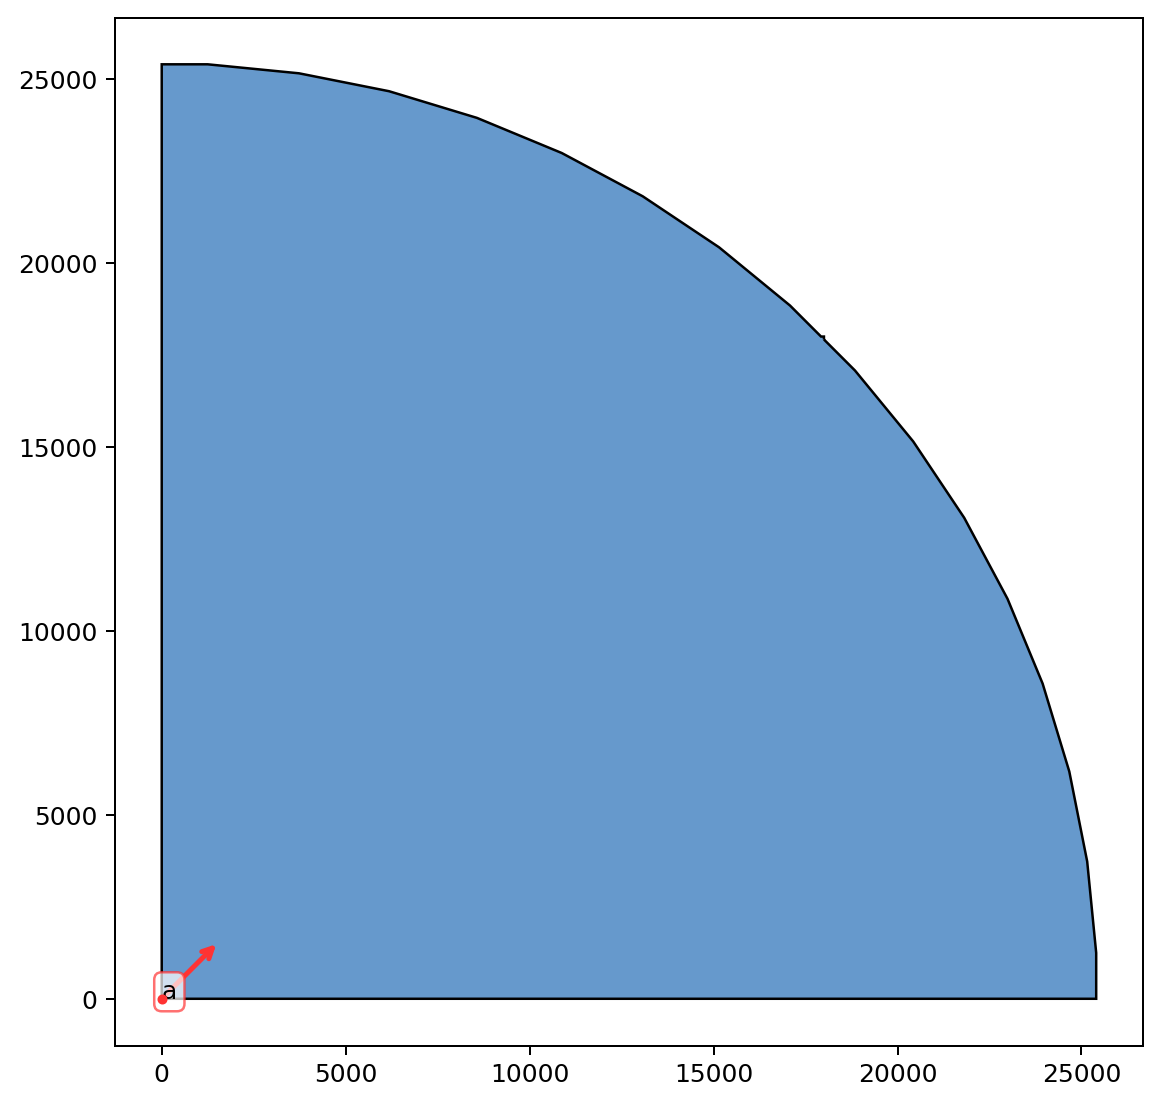

In [ ]:
plot_config = {"wafer": LIGHTGRAY,
               "bottom": YELLOW2,
               "gnd": BLUE,
               "top": ORANGE,
               "etch": VIOLET,
               "open": GREEN,
               "air": (GRAY,0.7),
               "skeletone": DARKGRAY,
               "anchors": RED}
route_config =  {"radius":100, "num_segments": 51}
gds = Reader_GDS(r"..\my_stuff\A_Quarter_2in_Wafer_2x7mm2_chips.gds")
print("Cells:", gds.cells)
gds.extract_geometries()
gds.import2zhk("TOP")
print("Geometries: ", gds.geometries)
t1 = GeomCollection(gds.geometries)
print("T1: ",t1)
plot_cfg = {"L1": BLUE, "L2": YELLOW2, "anchors": RED}

# Scale operation
t1.anchors.remove("a")
t1.add_anchor(Anchor((0,0), 45, "a"))
# Scale the geometries instead of t1.geom

t2=t1
t1.quickplot(plot_cfg)


In [ ]:
from shapely import intersects_xy
from shapely.geometry import box, Point
import numpy as np
import time



def start_timer(name):
    timings[name] = {'start': time.time(), 'splits': []}

def split_timer(name, split_name):
    current_time = time.time()
    if name in timings:
        split_time = current_time - timings[name]['start']
        timings[name]['splits'].append((split_name, split_time))
        print(f"{split_name}: {split_time:.2f} seconds")
        timings[name]['start'] = current_time

def is_chip_in_quarter_circle(x, y, chip_width, chip_height, radius):
    """
    Check if all corners of the chip are within the quarter circle
    
    Args:
        x, y: Bottom-left corner coordinates of the chip
        chip_width, chip_height: Dimensions of the chip
        radius: Radius of the quarter circle
    """
    # Check all four corners
    corners = [
        (x, y),  # bottom-left
        (x + chip_width, y),  # bottom-right
        (x, y + chip_height),  # top-left
        (x + chip_width, y + chip_height)  # top-right
    ]
    
    for corner_x, corner_y in corners:
        # Check if point is in first quadrant (positive x and y)
        if corner_x < 0 or corner_y < 0:
            return False
            
        # Check if point is within circle radius
        if (corner_x * corner_x + corner_y * corner_y) > radius * radius:
            return False
    
    return True

timings = {}
start_timer('main_process')

# Initialize
t1 = t2
circle_radius = 50800
pad_size = 200

route_config = {}
quarter_wafer = SuperStructure(route_config)
quarter_wafer.add_anchor(Anchor((0,0), 0, "c"))

split_timer('main_process', 'Initialization')



# Setup pad and chip
pad = Structure()
pad.add_layer("top", round_polygon(Square(pad_size), 40))
# pad.add_layer("gnd", pad.top.buffer(20))
pad.add_anchor(Anchor((0,0), -90, "o"))

chip = SuperStructure(plot_config)
Lx = 7000
Ly = 2000
spacing = 1000
offset = 250
chip.add_layer("bottom", Rectangle(Lx, Ly))

split_timer('main_process', 'Basic Setup')

# Setup chip template
coords_t = [(-Lx/2 + offset, spacing/2, 0)] + \
          [(-spacing*5/2 + spacing*i, Ly/2 - offset, -90) for i in range(6)] + \
          [(Lx/2 - offset, spacing/2, 180)]

coords_d = [(Lx/2 - offset, -spacing/2, 180)] + \
          [(spacing*5/2 - spacing*i, -Ly/2 + offset, 90) for i in range(6)] + \
          [(-Lx/2 + offset, -spacing/2, 0)]

for i, coord in enumerate(coords_t + coords_d):
    x, y,angle = coord
    chip.add_anchor(Anchor((x,y), angle, "p"+str(i)))
    print(chip.get_anchor("p"+str(i)))


for anc in chip.anchors.labels:
    print(chip.get_anchor(anc).point)
    chip.append(pad, anchoring=(anc, "o"), direction_snap=False, remove_anchor="o")
    chip.remove_anchor(anc)

if chip.get_anchor("left") == None:
    chip.add_anchor(Anchor((-2000,0),0,"left"))
else:
    chip.remove_anchor("left")
    chip.add_anchor(Anchor((-2000,0),0,"left"))

if chip.get_anchor("center") == None:
    chip.add_anchor(Anchor((0,0),0,"center"))
else:
    chip.remove_anchor("center")
    chip.add_anchor(Anchor((0,0),0,"center"))

if chip.get_anchor("right") == None:
    chip.add_anchor(Anchor((2000,0),0,"right"))
else:
    chip.remove_anchor("right")
    chip.add_anchor(Anchor((2000,0),0,"right"))

layer_config = {
    "top": 3,
    "gnd": 5
}

probe1 = FourPointProbe(950,100,layer_config,alabel=("p1"))

probe2 = FourPointProbe(950,50,layer_config,alabel=("p2"))
probe3 = FourPointProbe(950,10,layer_config,alabel=("p3"))

chip.append(probe1,("left","p1"),remove_anchor="p1")
chip.append(probe2,("center","p2"),remove_anchor="p2")
chip.append(probe3,("right","p3"),remove_anchor="p3")



for anc in chip.anchors.labels:
    chip.remove_anchor(anc)

chip.quickplot(plot_config)

Initialization: 0.00 seconds
Basic Setup: 0.01 seconds
<ANCHOR (POINT (-3250 500), 0.0, p0)>
<ANCHOR (POINT (-2500 750), -90.0, p1)>
<ANCHOR (POINT (-1500 750), -90.0, p2)>
<ANCHOR (POINT (-500 750), -90.0, p3)>
<ANCHOR (POINT (500 750), -90.0, p4)>
<ANCHOR (POINT (1500 750), -90.0, p5)>
<ANCHOR (POINT (2500 750), -90.0, p6)>
<ANCHOR (POINT (3250 500), 180, p7)>
<ANCHOR (POINT (3250 -500), 180, p8)>
<ANCHOR (POINT (2500 -750), 90.0, p9)>
<ANCHOR (POINT (1500 -750), 90.0, p10)>
<ANCHOR (POINT (500 -750), 90.0, p11)>
<ANCHOR (POINT (-500 -750), 90.0, p12)>
<ANCHOR (POINT (-1500 -750), 90.0, p13)>
<ANCHOR (POINT (-2500 -750), 90.0, p14)>
<ANCHOR (POINT (-3250 -500), 0.0, p15)>
POINT (-3250 500)
POINT (-2500 750)
POINT (-1500 750)
POINT (-500 750)
POINT (500 750)
POINT (1500 750)
POINT (2500 750)
POINT (3250 500)
POINT (3250 -500)
POINT (2500 -750)
POINT (1500 -750)
POINT (500 -750)
POINT (-500 -750)
POINT (-1500 -750)
POINT (-2500 -750)
POINT (-3250 -500)


ValueError: point label <ANCHOR (POINT (-500 775), 0.0, origin)> already exists in MultiAnchor.
                                 Choose different label name.

In [2]:


split_timer('main_process', 'Chip Template Setup')

# Calculate row positions with edge awareness
chip_width = 7000
chip_height = 2000
chip_spacing = 1000

def get_row_positions(y_pos):
    """Get valid x positions for a given y row, ensuring chips don't extend beyond circle"""
    positions = []
    x = 1000
    while True:
        if not is_chip_in_quarter_circle(x, y_pos, chip_width, chip_height, circle_radius):
            if x > circle_radius:  # Early exit if we're beyond circle
                break
            x += chip_width + chip_spacing
            continue
            
        positions.append((x, y_pos))
        x += chip_width + chip_spacing
    
    return positions

print("Placing chips row by row...")
total_chips = 0
y = 1000
row_times = []

while True:
    row_start = time.time()
    
    # Check if this row's bottom edge exceeds circle
    if y > circle_radius - chip_height:
        break
        
    # Get positions for this row
    row_positions = get_row_positions(y)
    if not row_positions:
        break
        
    print(f"Processing row at y={y} with {len(row_positions)} chips...")
    
    # Create row structure
    row = SuperStructure(route_config)
    
    # Add all chips in this row
    for i, (x, y_pos) in enumerate(row_positions):
        anchor_name = f"anc{i}"
        row.add_anchor(Anchor((x + chip_width/2, y_pos + chip_height/2), 0, anchor_name))
        row.append(chip, anchoring=(anchor_name, "chip_center"),
                  direction_snap=True, remove_anchor="chip_center")
        row.remove_anchor(anchor_name)
        total_chips += 1
    
    # Add completed row to quarter wafer
    quarter_wafer.append(row)
    
    row_time = time.time() - row_start
    row_times.append(row_time)
    print(f"Row completed in {row_time:.2f} seconds")
    
    y += chip_height + chip_spacing

split_timer('main_process', 'Chip Placement')

print("Adding layers...")
for layer_name in t1.layers:
    print(f"Processing layer: {layer_name}")
    current_geom = getattr(t1, layer_name)
    scaled_geom = aff.scale(current_geom, 2, 2, 1, (0,0,0))
    quarter_wafer.add_layer("wafer", scaled_geom)

split_timer('main_process', 'Layer Processing')

# Cleanup
quarter_wafer.remove_anchor("center")
quarter_wafer.remove_anchor("c")
pad.remove_anchor("o")
pad.remove_anchor("c","a")
t1.remove_anchor("a")

split_timer('main_process', 'Cleanup')

print("Plotting...")
plot_start = time.time()
quarter_wafer.quickplot(plot_config)
print(f"Plotting took {time.time() - plot_start:.2f} seconds")

# Print timing summary
print("\nTiming Summary:")
print("---------------")
for name, data in timings.items():
    print(f"\n{name} splits:")
    for split_name, time_taken in data['splits']:
        print(f"  {split_name}: {time_taken:.2f}s")

print("\nRow Processing Statistics:")
print(f"Total chips placed: {total_chips}")
print(f"Average row time: {sum(row_times)/len(row_times):.3f}s")
print(f"Min row time: {min(row_times):.3f}s")
print(f"Max row time: {max(row_times):.3f}s")
print(f"First row: {row_times[0]:.3f}s")
print(f"Last row: {row_times[-1]:.3f}s")

NameError: name 'split_timer' is not defined

In [ ]:
chip = SuperStructure(route_config)

Lx = 7000
Ly = 2000
spacing = 1000
offset = 250

# chip.add_layer("wafer", Rectangle(Lx, Ly))

coords_t = [(-Lx/2 + offset,spacing/2, 0)] + [(-spacing*5/2 + spacing*i, Ly/2 - offset, -90) for i in range(6)] + [(Lx/2 - offset,spacing/2, 180)]
coords_d = [(Lx/2 - offset,-spacing/2, 180)] + [(spacing*5/2 - spacing*i, -Ly/2 + offset, 90) for i in range(6)] + [(-Lx/2 + offset,-spacing/2, 0)]

for i, coord in enumerate(coords_t + coords_d):
    x, y, angle = coord
    chip.add_anchor(Anchor((x,y), angle, "p"+str(i)))

for anc in chip.anchors.labels:
    chip.append(pad, anchoring=(anc, "o"), direction_snap=True, remove_anchor="o")




chip.quickplot(plot_config)

AttributeError: 'NoneType' object has no attribute 'direction'